# LSS applied to CA-backbone of BBA fast-folding protein


## Load the different components from their respective repos

In [1]:
from mdn_propagator.propagator import Propagator
from molgen.models import DDPM
from snrv import Snrv

### Other dependencies

In [2]:
import mdtraj as md
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import nglview as nv

import seaborn as sns
from scipy.stats import pearsonr

# Load 10 DESRES trajectories for training

In [3]:
# load the

load_path = '/project/andrewferguson/DESRES/DESRES-Trajectory_1FME-0-c-alpha/1FME-0-c-alpha'
trj_fnames = sorted(glob.glob(f'{load_path}/1FME-0-c-alpha-00*.dcd'))
top_fname = f'{load_path}/1FME-0-c-alpha.pdb'
save_freq = 200 # ps

In [4]:
# load  frame

trjs = [md.load(t, top=top_fname).center_coordinates() for t in trj_fnames]
print(len(trjs), trjs[0].xyz.shape)

10 (100000, 28, 3)


In [5]:
# view an example trj

v = nv.show_mdtraj(trjs[3])
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=99999)

In [6]:
# extract all (inverse) distances between CA as features -- 28 residues == 378 featurse

coords_torch = list()
for trj in trjs:
    pdists = [torch.pdist(p)[None] for p in torch.tensor(trj.xyz)]
    coords_torch.append(torch.cat(pdists))
len(coords_torch), coords_torch[0].shape

(10, torch.Size([100000, 378]))

In [7]:
# extract some physically relevant features -- probably don't need this?

ref_trj = trjs[0]

h2t_list = []
rmsd_list = []

for trj in trjs:
    h2t = md.compute_distances(trj, [[0, 27]])[:, 0]
    h2t_list.append(h2t)
    
    rmsd = md.rmsd(trj, ref_trj, 0)
    rmsd_list.append(rmsd)
    
h2t_list = np.concatenate(h2t_list)
rmsd_list = np.concatenate(rmsd_list)

In [8]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SRV fitting

In [9]:
from snrv.utils import set_random_seed

In [10]:
set_random_seed(42)

Setting random seed to 42


In [11]:
# train for 3 epochs (1_000_000 frames each) to avoid overfitting

input_size = coords_torch[0].size()[1]
output_size = 7
hidden_depth = 2
hidden_size = 100
batch_norm = True
dropout_rate = 0.0
lr = 1E-2
weight_decay = 0.0
val_frac = 0.05
n_epochs = 3
batch_size = 25000
VAMPdegree = 2
is_reversible = True
num_workers = 0

model_snrv = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree,is_reversible=is_reversible, num_workers=num_workers,
            activation=torch.nn.GELU(), device=device)

model_snrv = model_snrv.to(device)

In [12]:
lag_n = 50  # (10 ns)  selected based on previous hyperparam check

load_pretrained_snrv = True
save_new_model = False
model_save_path = './BBA_pretrained/model_snrv-3.pth'

if load_pretrained_snrv:
    ckp = torch.load(model_save_path)
    model_snrv.load_state_dict(ckp['model_state_dict'])
    model_snrv.training_losses = ckp['training_losses']
    model_snrv.validation_losses = ckp['validation_losses']
    model_snrv.evals = ckp['evals']
    model_snrv.expansion_coefficients = ckp['expansion_coefficients']
    model_snrv.is_fitted = True
    
else:
    model_snrv.fit(coords_torch, lag=lag_n, scheduler=0.98)
    if save_new_model:
        torch.save(model_snrv.state_dict(), model_save_path)
        
        torch.save({
        'model_state_dict': model_snrv.state_dict(),
        'training_losses': model_snrv.training_losses,
        'validation_losses': model_snrv.validation_losses,
        'evals': model_snrv.evals,
        'expansion_coefficients': model_snrv.expansion_coefficients,
        }, model_save_path)

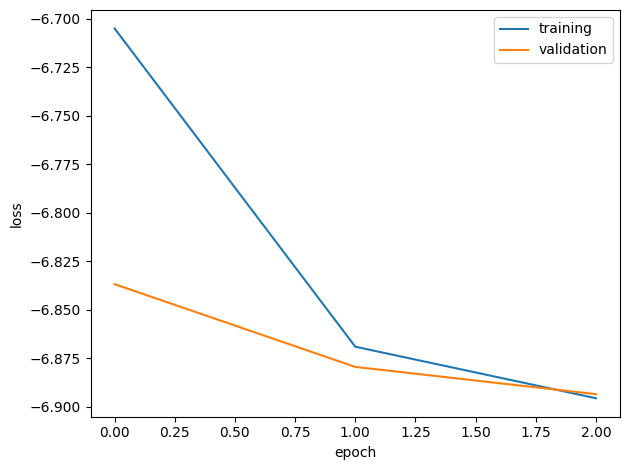

In [13]:
# after 5 epochs, training di

fig, ax = plt.subplots()
ax.plot(np.arange(len(model_snrv.training_losses)), model_snrv.training_losses)
ax.plot(np.arange(len(model_snrv.validation_losses)), model_snrv.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

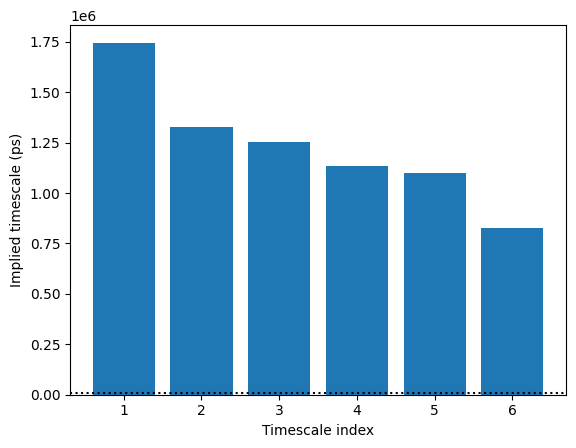

In [14]:
evals = model_snrv.evals.cpu().detach().numpy()
plt.bar(range(1, evals.size), -lag_n*save_freq/np.log(evals[1:]))  # by default use evals[1:]
plt.ylabel('Implied timescale (ps)')
plt.xticks(range(1, evals.size))
plt.xlabel('Timescale index')
plt.axhline(lag_n*save_freq, color='k', linestyle=':')

In [15]:
model_snrv.eval()

Snrv(
  (activation): GELU(approximate='none')
  (model): Sequential(
    (0): Linear(in_features=378, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=100, out_features=7, bias=True)
  )
)

In [16]:
evecs = model_snrv.transform(torch.cat(coords_torch)).cpu().detach().numpy()
print(evecs.shape)

(1000000, 7)


In [17]:
import deeptime as dt
tica = dt.decomposition.TICA(lagtime=5, dim=2)
TICs = tica.fit_transform([a.numpy() for a in coords_torch]).reshape(-1, 2)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

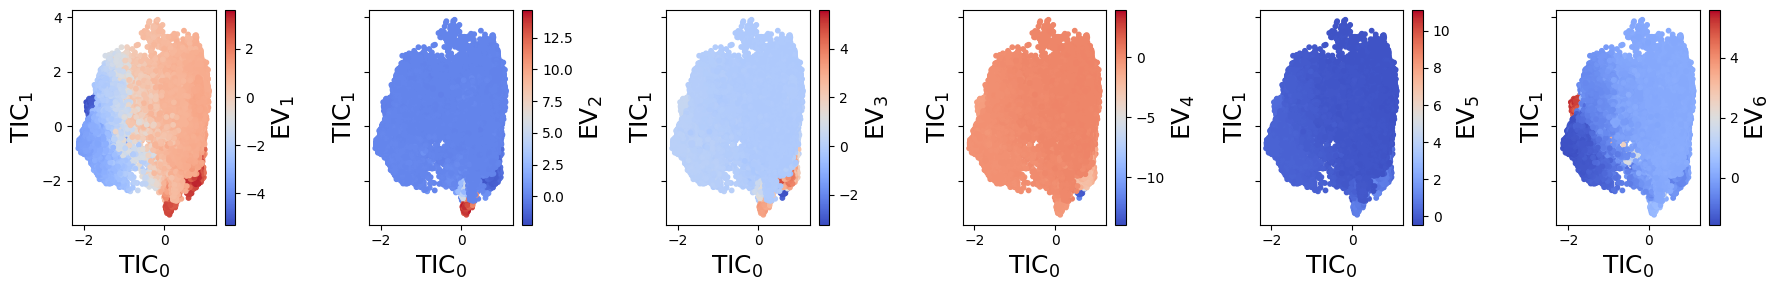

In [18]:
fig, axes = plt.subplots(1, 6, figsize = (18, 3), sharey=True, sharex=True)
axes = axes.flatten()
stride = 10

for e in range(1, evecs.shape[1]):
    evec = evecs[::stride, e]
    ax = axes[e-1]
    
    im = ax.scatter(TICs[::stride, 0], TICs[::stride, 1], c=evec, s=10, cmap='coolwarm')
    ax.set_xlabel('$TIC_0$', fontsize=18)
    ax.set_ylabel('$TIC_1$', fontsize=18)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'EV$_{e}$', size=18)

plt.tight_layout()

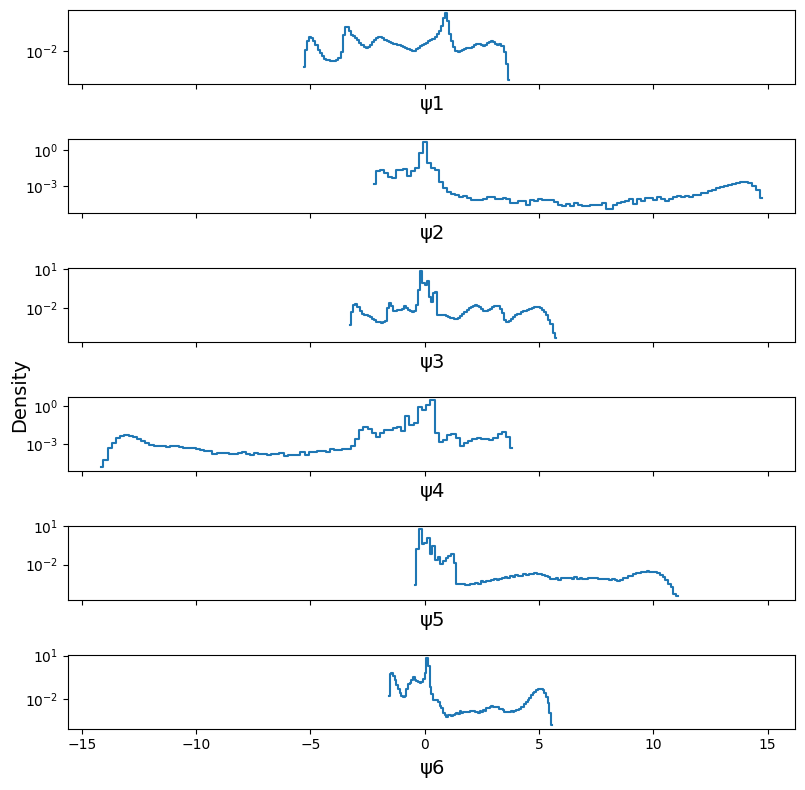

In [34]:
# check where transitions show up over trajectories

evec_idx = 4
nbins = 100
ntrjs = 10

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)

for evec_idx, ax in enumerate(axes):
    bins = np.linspace(np.min(evecs[:, evec_idx+1]), np.max(evecs[:, evec_idx+1]), nbins)
    counts, bin_edges = np.histogram(evecs[:, evec_idx+1], bins=bins, density=True)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    free_energy = -np.log(counts + 1e-10)
    
    #ax.plot(bin_centers, free_energy, drawstyle='steps-mid')
    ax.plot(bin_centers, counts, drawstyle='steps-mid')
    ax.set_xlabel(f'$\psi{evec_idx+1}$', fontsize=14)
    ax.set_yscale('log')
    
fig.text(0.0, 0.5, 'Density', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()


Text(145.72222222222223, 0.5, 'Residue index')

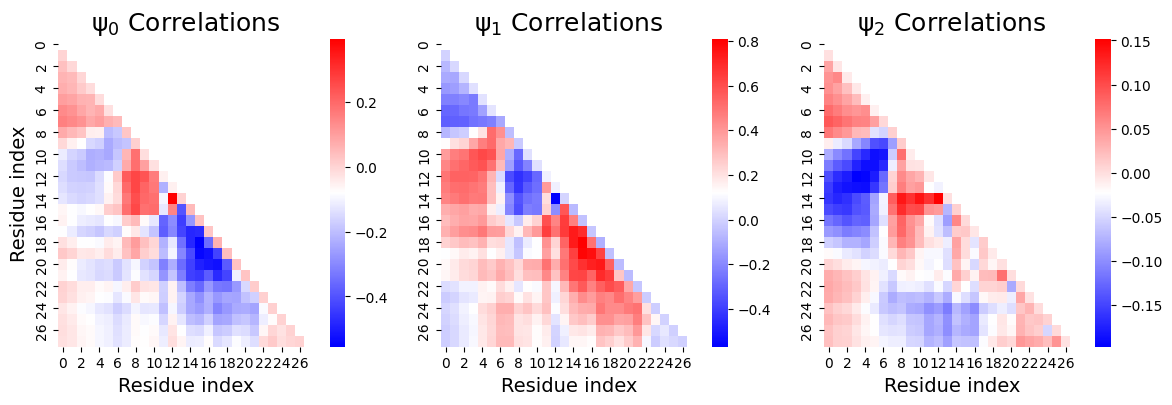

In [20]:
# Interpret modesl by checking correlations against input features (pairwise distances)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

all_feats = np.concatenate(coords_torch)
num_features = all_feats.shape[1]
nres = trjs[0].n_residues

for evec_idx, ax in enumerate(axes):

    heatmap = np.zeros((nres, nres))
    correlations = np.zeros(num_features)
    cnt = 0
    
    for i in range(num_features):
        correlations[i], _ = pearsonr(all_feats[:, i], evecs[:, evec_idx])

    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap[i, j] = correlations[cnt]
            heatmap[j, i] = correlations[cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap, dtype=bool))
    sns.heatmap(heatmap, mask=mask, cmap='bwr', ax=ax)

    ax.set_title(f'$\psi_{evec_idx}$ Correlations', fontsize=18)
    ax.set_xlabel('Residue index', fontsize=14)
    
axes[0].set_ylabel('Residue index', fontsize=14)
    

In [21]:
# can remove these

def find_longest_consecutive_sequence(arr):
    
    if len(arr) == 0:
        return []

    # Initialize variables
    longest_streak = []
    current_streak = [arr[0]]

    # Iterate through the array
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_streak.append(arr[i])
        else:
            if len(current_streak) > len(longest_streak):
                longest_streak = current_streak
            current_streak = [arr[i]]

    # Final check for the longest streak at the end of the array
    if len(current_streak) > len(longest_streak):
        longest_streak = current_streak

    return longest_streak

def find_all_consecutive_sequence_ranges(arr):
    if len(arr) == 0:
        return []
    
    # Initialize variables
    streaks = []
    current_streak_start = arr[0]
    current_streak_end = arr[0]

    # Iterate through the array
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_streak_end = arr[i]
        else:
            streaks.append((current_streak_start, current_streak_end))
            current_streak_start = arr[i]
            current_streak_end = arr[i]

    # Add the last streak to the list
    streaks.append((current_streak_start, current_streak_end))

    # Sort the streaks by length from longest to shortest
    streaks.sort(key=lambda x: x[1] - x[0], reverse=True)

    return streaks

Text(0.08, 0.5, 'Residue Index')

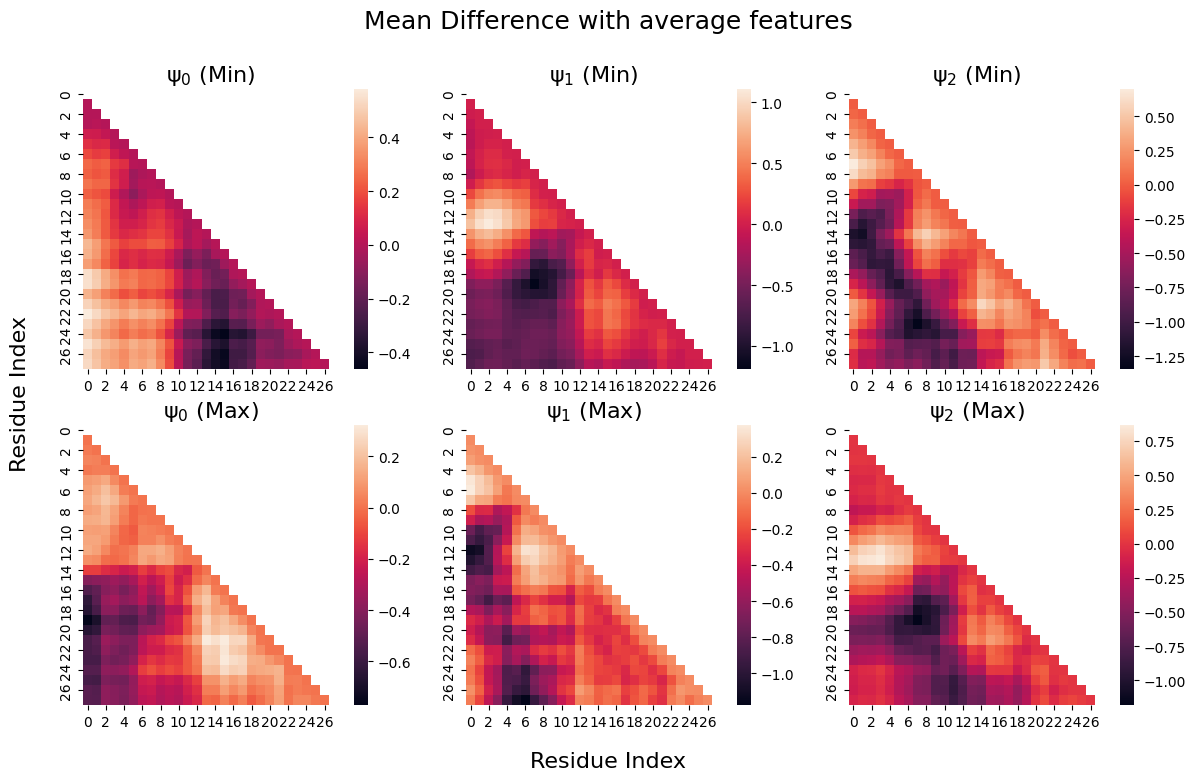

In [22]:
# identify and visualize different metastable states
# average over the 1000 highest and lowest values that eahc thetevenc

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
max_frames = 1000

for evec_idx, ax_row in enumerate(axes.T):

    evec_mins = np.argsort(evecs[:, evec_idx])[-max_frames:]
    evec_maxs = np.argsort(evecs[:, evec_idx])[:max_frames]

    #frame_idxs = np.where((evecs[:, evec_idx] > span[0]) & (evecs[:, evec_idx] < span[1]))[0]

    # print a set of consecutive frame idxs

    ref_means = np.mean(all_feats, axis=0)

    heatmap_mins = np.zeros((nres, nres))
    heatmap_maxs = np.zeros((nres, nres))

    cnt = 0
    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap_mins[j, i] = np.mean(all_feats[evec_mins, cnt]) - ref_means[cnt]
            heatmap_maxs[j, i] = np.mean(all_feats[evec_maxs, cnt]) - ref_means[cnt]
            cnt += 1

    #longest_consecutive_series = find_longest_consecutive_sequence(frame_idxs)
    #all_consecutive_sequence_ranges = find_all_consecutive_sequence_ranges(frame_idxs)

    #print(len(longest_consecutive_series), longest_consecutive_series)
    #for streak in all_consecutive_sequence_ranges[:10]:
    #    print(streak[1] - streak[0]  + 1, streak)
    
    mask = np.triu(np.ones_like(heatmap_mins, dtype=bool))
    sns.heatmap(heatmap_mins, mask=mask, ax=ax_row[0])
    sns.heatmap(heatmap_maxs, mask=mask, ax=ax_row[1])
    
    ax_row[0].set_title(f'$\psi_{evec_idx}$ (Min)', fontsize=16)
    ax_row[1].set_title(f'$\psi_{evec_idx}$ (Max)', fontsize=16)
    
fig.suptitle('Mean Difference with average features', fontsize=18)
fig.text(0.5, 0.04, 'Residue Index', ha='center', va='center', fontsize=16)
fig.text(0.08, 0.5, 'Residue Index', ha='center', va='center', rotation='vertical', fontsize=16)


In [23]:
v = nv.show_mdtraj(trjs[6])
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=99999)

In [24]:
CVs = [model_snrv.transform(x).cpu().detach()[:, 1:] for x in coords_torch]
CVs[0].shape, len(CVs)

(torch.Size([100000, 6]), 10)

# MDN propagator

In [53]:
model_mdn = Propagator(dim = CVs[0].size(1))

In [54]:
lag_mdn = 50   # set to same as SRV for now but this does not need to be the case

load_pretrained_mdn = True
save_new_model = False
model_save_path = './BBA_pretrained/model_mdn-100.pth'

if load_pretrained_mdn:
    model_mdn.load_state_dict(torch.load(model_save_path))
    model_mdn.is_fit = True
    
else:
    model_mdn.fit(CVs, lag = 10, max_epochs=100)
    if save_new_model:
        torch.save(model_mdn.state_dict(), model_save_path)


/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/midway2/mikejones/conda_env/torchcfm_11.8/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /scratch/midway2/mikejones/lss-seq/LSS/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type                  | Params
---------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [79]:
n_steps = 10 * len(evecs) / lag_n
x = CVs[0][0][None]
synthetic_traj_CVs = model_mdn.gen_synthetic_traj(x, n_steps)
synthetic_traj_CVs.shape

  0%|          | 0/200000 [00:00<?, ?it/s]

torch.Size([200000, 6])

Text(0.5, 0, 'N lag times (10 ns)')

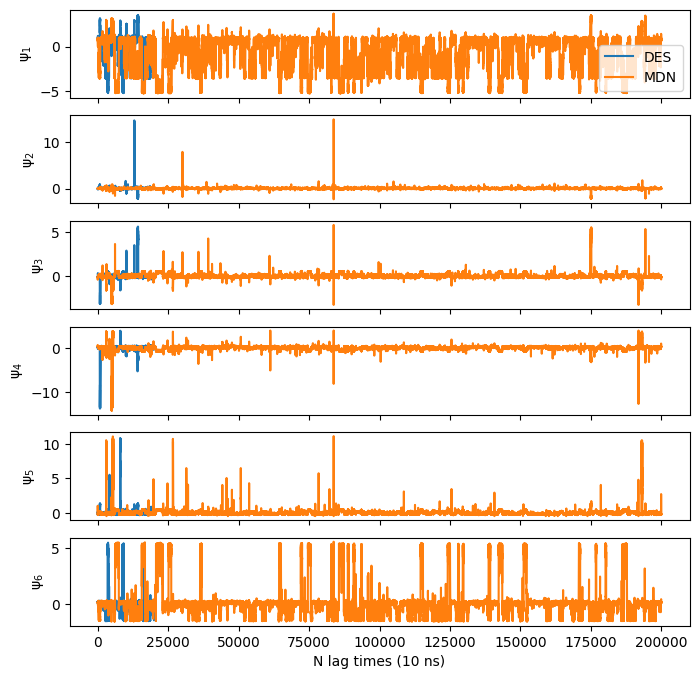

In [80]:
# compare plots of all evecs across time 

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)
    
for evec_idx, ax in enumerate(axes):
    ax.plot(evecs[::lag_n, evec_idx+1], label='DES')
    ax.plot(synthetic_traj_CVs[:, evec_idx], label='MDN')
    ax.set_ylabel(f'$\psi_{evec_idx+1}$')
    
axes[0].legend()
axes[-1].set_xlabel('N lag times (10 ns)')

/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_ol

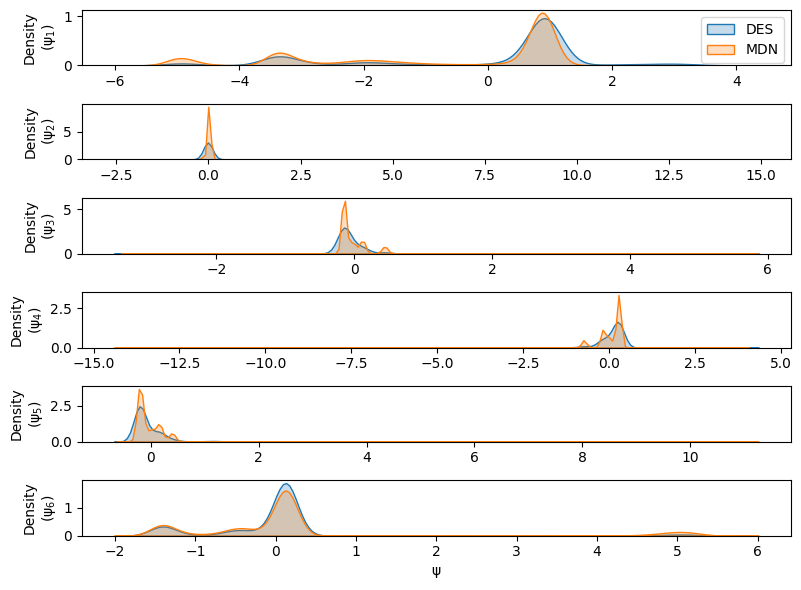

In [81]:
# histograms of all evecs across time -- ensures thermodynamics are approximately reproduced

fig, axes = plt.subplots(6, figsize=(8, 6), sharex=False)

evecs = np.array(evecs)
synthetic_traj_CVs = np.array(synthetic_traj_CVs)
evecs[np.isinf(evecs)] = np.nan
synthetic_traj_CVs[np.isinf(synthetic_traj_CVs)] = np.nan
    
for evec_idx, ax in enumerate(axes):
    sns.kdeplot(evecs[::lag_n, evec_idx+1], ax=ax, label='DES', fill=True)
    sns.kdeplot(synthetic_traj_CVs[:, evec_idx], ax=ax, label='MDN', fill=True)
    ax.set_ylabel(f'Density\n($\psi_{evec_idx+1}$)')

axes[0].legend()
axes[-1].set_xlabel('$\psi$')

plt.tight_layout()
plt.show()


# DDPM Decoder

In [61]:
# flatten coordiantes before passing to DDPM

n = trjs[0].xyz.shape[0]
xyz = [torch.tensor(trj.xyz.reshape(n, -1)).float() for trj in trjs]

print(xyz[0].shape)

torch.Size([100000, 84])


In [62]:
# uses 1000 steps by default, but 50-100 will be much faster and should work fine

model_ddpm = DDPM(xyz[0].shape[1], CVs[0].shape[1])

In [66]:
%time

load_pretrained_ddpm = True
save_new_model = False
model_save_path = './BBA_pretrained/model_ddpm-25.pth'

if load_pretrained_ddpm:
    model_ddpm.load_state_dict(torch.load(model_save_path))
    model_ddpm.is_fit = True
    
else:
    model_ddpm.fit(xyz, CVs, max_epochs=25)
    if save_new_model:
        torch.save(model_ddpm.state_dict(), model_save_path)

CPU times: user 0 ns, sys: 21 µs, total: 21 µs
Wall time: 41.7 µs


In [67]:
synthetic_traj_CVs.shape

(20000, 6)

In [69]:
# Decode a set of real SRV coordinates first and check adherence to conditioning

# each xyz idx should correspond to trj idx
trj_ref = md.join([trj[0] for trj in trjs])
evecs_ref = evecs[::100_000, 1:]

xyz_gen = model_ddpm.generate(torch.Tensor(evecs_ref))
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()
fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)
fake_trj = md.join([ft.superpose(rf) for ft, rf in zip(fake_trj, trj_ref)])

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
v = nv.show_mdtraj(trj_ref)
v.add_trajectory(fake_trj)

v[0].clear_representations()
v[0].add_representation('ball+stick', color='blue')

v[1].clear_representations()
v[1].add_representation('ball+stick', color='red')
v

NGLWidget(max_frame=9)

Text(374.59934086629, 0.5, 'Fake Traj')

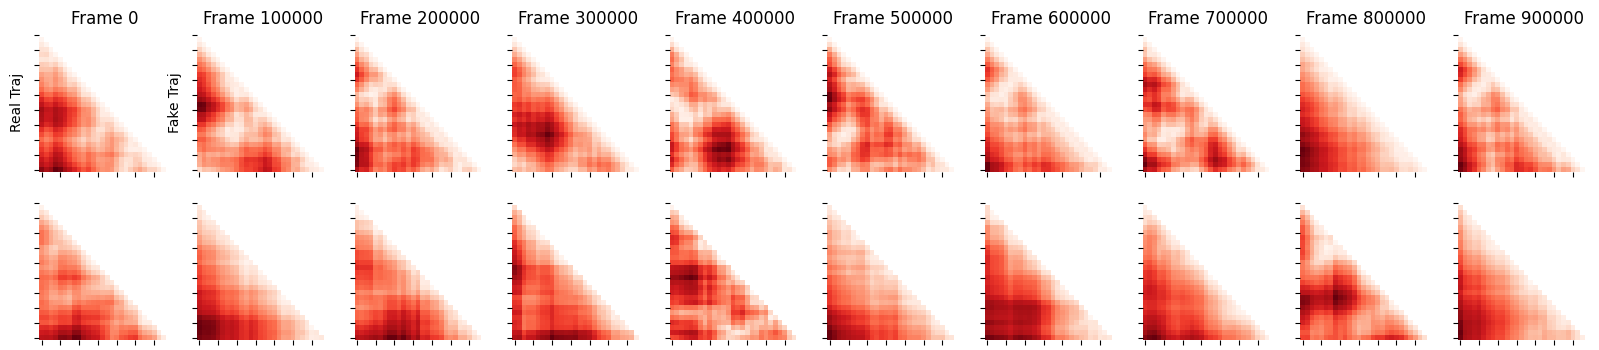

In [78]:
# calculate pairwise distances between each ref and gen structure
# we should observe similar profiles between the top row and bottom row plots

pdists_ref = [torch.pdist(p)[None] for p in torch.tensor(trj_ref.xyz)]
pdists_gen = [torch.pdist(p)[None] for p in torch.tensor(fake_trj.xyz)]

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for f, (p_ref, p_gen, ax_row) in enumerate(zip(pdists_ref, pdists_gen, axes.T)):

    heatmap_ref = np.zeros((nres, nres))
    heatmap_gen = np.zeros((nres, nres))

    cnt = 0
    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap_ref[j, i] = p_ref[0, cnt].numpy()
            heatmap_gen[j, i] = p_gen[0, cnt].numpy()
            cnt += 1
            
    mask = np.triu(np.ones_like(heatmap_ref, dtype=bool))
    sns.heatmap(heatmap_ref, mask=mask, cmap='Reds', ax=ax_row[0], cbar=False)
    sns.heatmap(heatmap_gen, mask=mask, cmap='Reds', ax=ax_row[1], cbar=False)
    ax_row[0].set_title(f'Frame {f*100_000}')
            
for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
axes[0, 0].set_ylabel('Real Traj')
axes[0, 1].set_ylabel('Fake Traj')


# Decode synthetic traj

In [73]:
xyz_gen = model_ddpm.generate(torch.Tensor(synthetic_traj_CVs[:20]))

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()
fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)

In [75]:
# decode first frame of each traj (each has different embeddings)

xyz_ref = [trj.xyz for trj in trjs]
evec_ref = evecs[:10]

# Visualize results

In [76]:
import nglview as nv

In [77]:
v = nv.show_mdtraj(fake_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=19)

In [34]:
#fake_trj.save_pdb('BBA_Ca_synthetic_traj.pdb')